In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")

In [3]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
train["day"].nunique() ##Checking if the day column includes leap days

365

In [5]:
train["rainfall"].value_counts() ##Checking how balanced the classes are

rainfall
1    1650
0     540
Name: count, dtype: int64

In [6]:
train.drop(columns=['id', 'day', 'rainfall']).describe() ##checking summary, looking for outliers, nothing too egregious

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703
std,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659
min,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000
25%,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000
50%,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000
75%,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000
max,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000


In [7]:
train.isnull().sum() ##checking for nulls

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [8]:
##Checking for multicollinearity

In [9]:
X = train.drop(columns = ['id','day','rainfall'])
corr_matrix = X.corr()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


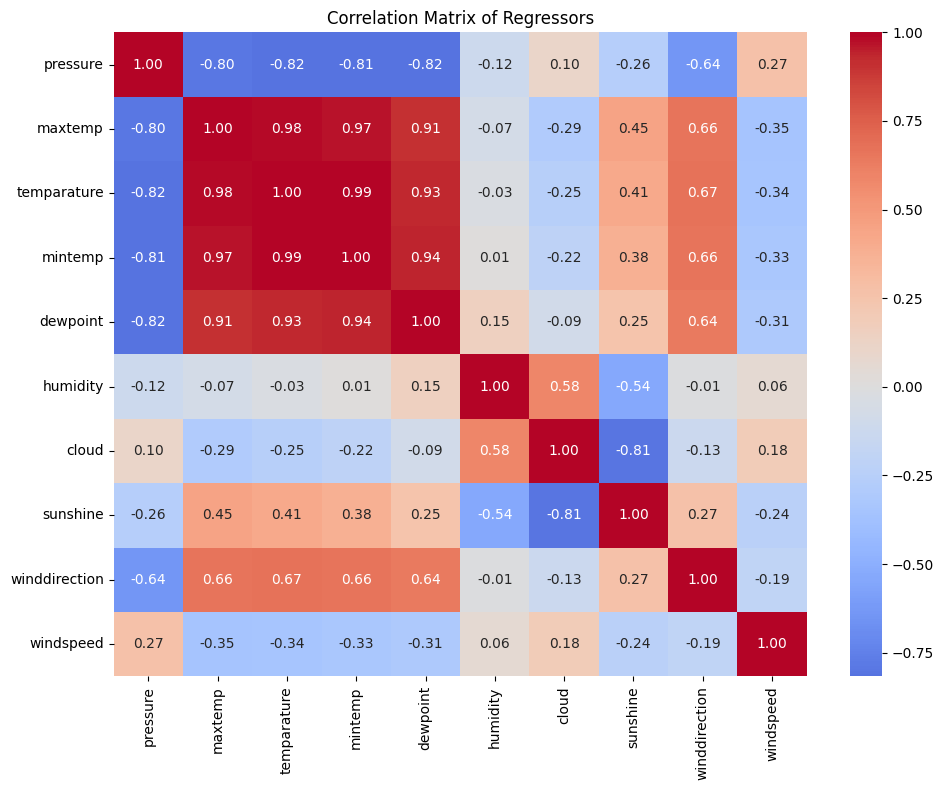

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Regressors")
plt.tight_layout()
plt.show()

In [11]:
## It looks like dewpoint is redundant with the temperature cols. Also, we don't need all the temp cols. Maybe just temperature + temp range?

In [12]:
## Time to do some feature engineering now

In [13]:
##Creating a categorical variable for month
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_edges = np.cumsum([1] + days_in_month)
month_indices = np.searchsorted(month_edges[1:], train['day'])
train['month'] = [month_names[i] for i in month_indices]

In [14]:
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,Jan
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,Jan
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,Jan
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,Jan
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,Dec
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,Dec
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,Dec
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1,Dec


In [15]:
train['temp_range'] = train['maxtemp']-train['mintemp']

In [16]:
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month,temp_range
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,Jan,1.3
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,Jan,0.4
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,Jan,4.8
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,Jan,1.2
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,Jan,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,Dec,4.1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,Dec,0.9
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,Dec,4.7
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1,Dec,2.6


In [17]:
train['temperature'] = train['temparature'] ## fixing the annoying spelling error

In [18]:
train_final = train.drop(columns = ['id','day','temparature','maxtemp','mintemp','dewpoint'])

In [19]:
train_final

,pressure,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month,temp_range,temperature
0,1017.4,87.0,88.0,1.1,60.0,17.2,1,Jan,1.3,20.6
1,1019.5,95.0,91.0,0.0,50.0,21.9,1,Jan,0.4,16.9
2,1024.1,75.0,47.0,8.3,70.0,18.1,1,Jan,4.8,16.1
3,1013.4,95.0,95.0,0.0,60.0,35.6,1,Jan,1.2,17.8
4,1021.8,52.0,45.0,3.6,40.0,24.8,0,Jan,6.1,18.4
...,...,...,...,...,...,...,...,...,...,...
2185,1014.6,97.0,88.0,0.1,40.0,22.1,1,Dec,4.1,20.6
2186,1012.4,91.0,88.0,0.0,50.0,35.3,1,Dec,0.9,17.3
2187,1013.3,79.0,79.0,5.0,40.0,32.9,1,Dec,4.7,16.3
2188,1022.3,92.0,93.0,0.1,40.0,18.0,1,Dec,2.6,15.2


In [20]:
##Lets train

In [21]:
train_ohe = pd.get_dummies(train_final, columns=['month'], drop_first=True) ##OHE for the logistic regression
X_ohe = train_ohe.drop(columns='rainfall')
y = train_ohe['rainfall']

In [22]:
train_le = train_final.copy() ## label encoding for XGboost
train_le['month'] = LabelEncoder().fit_transform(train_le['month'])
X_le = train_le.drop(columns='rainfall')
y = train_le['rainfall']

In [23]:
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=4444)
X_train_le, X_test_le, _, _ = train_test_split(X_le, y, test_size=0.2, random_state=4444)

In [24]:
## Random Forest
rf = RandomForestClassifier(random_state=4444)
rf.fit(X_train_ohe, y_train)

## XGBoost 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=4444)
xgb.fit(X_train_le, y_train)

## Logistic Regression
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=4444)
)
logreg.fit(X_train_ohe, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=4444))])

In [25]:
## Get probability predictions
rf_probs = rf.predict_proba(X_test_ohe)[:, 1]
xgb_probs = xgb.predict_proba(X_test_le)[:, 1]
logreg_probs = logreg.predict_proba(X_test_ohe)[:, 1]

## Compute AUC scores
auc_rf = roc_auc_score(y_test, rf_probs)
auc_xgb = roc_auc_score(y_test, xgb_probs)
auc_logreg = roc_auc_score(y_test, logreg_probs)

print(f"AUC - Random Forest:       {auc_rf:.4f}")
print(f"AUC - XGBoost:             {auc_xgb:.4f}")
print(f"AUC - Logistic Regression: {auc_logreg:.4f}")

AUC - Random Forest:       0.8514
AUC - XGBoost:             0.8403
AUC - Logistic Regression: 0.8749


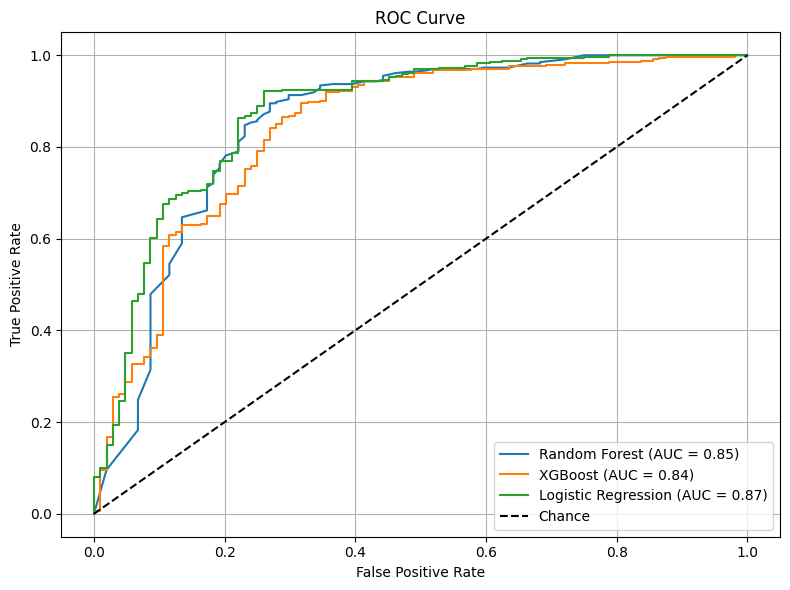

In [26]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_log, tpr_log, _ = roc_curve(y_test, logreg_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
## Lets try cross validation to ensure that logistic regression is actually the best
cv_rf = cross_val_score(rf, X_ohe, y, cv=10, scoring='roc_auc')
cv_logreg = cross_val_score(logreg, X_ohe, y, cv=10, scoring='roc_auc')
cv_xgb = cross_val_score(xgb, X_le, y, cv=10, scoring='roc_auc')

print(f"Cross-validated AUC - Random Forest:       {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")
print(f"Cross-validated AUC - XGBoost:             {cv_xgb.mean():.4f} ± {cv_xgb.std():.4f}")
print(f"Cross-validated AUC - Logistic Regression: {cv_logreg.mean():.4f} ± {cv_logreg.std():.4f}")

Cross-validated AUC - Random Forest:       0.8757 ± 0.0306
Cross-validated AUC - XGBoost:             0.8601 ± 0.0312
Cross-validated AUC - Logistic Regression: 0.8851 ± 0.0196


In [28]:
##Lets try some hyperparameter tuning as well to be sure out our result
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

logreg_param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10],  ##inverse regularization strength
    'logisticregression__penalty': ['l2']
}


In [29]:
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=4444),
    rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
rf_grid.fit(X_ohe, y)

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=4444),
    xgb_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
xgb_grid.fit(X_le, y)

logreg_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=4444))
logreg_grid = GridSearchCV(
    logreg_pipe,
    logreg_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
logreg_grid.fit(X_ohe, y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=4444))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10],
                         'logisticregression__penalty': ['l2']},
             scoring='roc_auc')

In [30]:
print("Best AUC (Random Forest):       ", rf_grid.best_score_)
print("Best Params (Random Forest):    ", rf_grid.best_params_)

print("Best AUC (XGBoost):             ", xgb_grid.best_score_)
print("Best Params (XGBoost):          ", xgb_grid.best_params_)

print("Best AUC (Logistic Regression): ", logreg_grid.best_score_)
print("Best Params (Logistic):         ", logreg_grid.best_params_)

Best AUC (Random Forest):        0.8821661054994389
Best Params (Random Forest):     {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC (XGBoost):              0.8853423120089786
Best Params (XGBoost):           {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best AUC (Logistic Regression):  0.8901459034792369
Best Params (Logistic):          {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}


In [31]:
##Even after cross validation and hyperparameter tuning, logistic regression performs best

In [32]:
##lets create the submission file
logreg_final = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=4444)
)

logreg_final.set_params(
    logisticregression__C=0.01,
    logisticregression__penalty='l2'
)

logreg_final.fit(X_ohe, y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=4444))])

In [33]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

In [34]:
test

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3
726,2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2
727,2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9
728,2918,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5


In [35]:
##Creating a categorical variable for month
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_edges = np.cumsum([1] + days_in_month)
month_indices = np.searchsorted(month_edges[1:], test['day'])
test['month'] = [month_names[i] for i in month_indices]

test['temp_range'] = test['maxtemp']-test['mintemp']
test['temperature'] = test['temparature']

In [36]:
test_final = test.drop(columns = ['day','temparature','maxtemp','mintemp','dewpoint'])

In [37]:
test_final

,id,pressure,humidity,cloud,sunshine,winddirection,windspeed,month,temp_range,temperature
0,2190,1019.5,96.0,99.0,0.0,50.0,24.3,Jan,4.8,15.8
1,2191,1016.5,97.0,99.0,0.0,50.0,35.3,Jan,1.7,16.5
2,2192,1023.9,86.0,96.0,0.0,40.0,16.9,Jan,1.8,10.4
3,2193,1022.9,75.0,45.0,7.1,20.0,50.6,Jan,5.4,17.3
4,2194,1022.2,68.0,49.0,9.2,20.0,19.4,Jan,9.7,13.8
...,...,...,...,...,...,...,...,...,...,...
725,2915,1020.8,96.0,95.0,0.0,20.0,34.3,Dec,2.1,17.6
726,2916,1011.7,78.0,80.0,1.6,40.0,25.2,Dec,7.2,18.1
727,2917,1022.7,92.0,96.0,0.0,50.0,21.9,Dec,4.0,18.5
728,2918,1014.4,94.0,93.0,0.0,50.0,39.5,Dec,1.3,20.0


In [38]:
test_ohe = pd.get_dummies(test_final, columns=['month'], drop_first=True)

In [39]:
X_test = test_ohe.drop(columns = "id")

In [40]:
X_test.isna().sum()

pressure         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
temp_range       0
temperature      0
month_Aug        0
month_Dec        0
month_Feb        0
month_Jan        0
month_Jul        0
month_Jun        0
month_Mar        0
month_May        0
month_Nov        0
month_Oct        0
month_Sep        0
dtype: int64

In [41]:
predictions = logreg_final.predict(X_test)

In [42]:
predicted_probs = logreg_final.predict_proba(X_test)[:, 1]

In [43]:
test_final["rainfall"] = predicted_probs

In [44]:
submission_file = test_final[["id","rainfall"]]

In [45]:
submission_file

,id,rainfall
0,2190,0.962431
1,2191,0.973649
2,2192,0.917796
3,2193,0.262855
4,2194,0.118654
...,...,...
725,2915,0.959984
726,2916,0.809587
727,2917,0.943011
728,2918,0.965285


In [46]:
submission_file.to_csv("/kaggle/working/submission.csv",index = False)

In [47]:
submission_file["rainfall"].min()

0.004514616746924679

In [48]:
submission_file["rainfall"].max()

0.9784995331358021